# Phase 1: Data Loading and Exploration

## Load Data and Attach Feature Names
In this step, we will load the KDD Cup 1999 dataset from Google Drive into a Pandas DataFrame. Additionally, we will read the feature names from the `kddcup.names` file and attach them to our DataFrame. We'll use the 10% subset of the dataset for initial exploration.


### Import necessary libraries

In [86]:
# General libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

# Sci-kit learn libraries
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Dynamic graph embedding libraries
import networkx as nx
from node2vec import Node2Vec

# System libraries
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [8]:
# Define the path to the dataset and the feature names file
data_path = "data/kddcup.data_10_percent.gz"
names_path = "data/kddcup.names"

# Read feature names
with open(names_path, 'r') as f:
    lines = f.readlines()[1:]  # skip the first line
feature_names = [line.split(':')[0] for line in lines]
feature_names += ['target']  # The target variable is not in the .names file

# Load the dataset into a Pandas DataFrame and attach feature names
df = pd.read_csv(data_path, compression='gzip', header=None, names=feature_names)

## Initial Data Exploration
After attaching the feature names, let's take an initial look at the data to understand its structure, dimensions, and feature types.


In [9]:
# Show the first few rows of the DataFrame
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [10]:
# Display the shape and data types of the DataFrame
print("Shape of the DataFrame:", df.shape)
print("\nData Types:\n", df.dtypes)

Shape of the DataFrame: (494021, 42)

Data Types:
 duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate  

# Phase 2: Exploratory Data Analysis (EDA)


## Summary Statistics
In this step, we will generate summary statistics for numerical features to understand their distribution, count, mean, standard deviation, and range.


In [11]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Check for Missing Values
We need to identify if there are any missing values in the dataset, as they could impact the performance of our machine learning models.


In [12]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

The dataset contains no missing values for any of the features or the target variable. This is a positive aspect, as it means we don't need to perform imputation or removal of incomplete records, allowing us to move forward without worrying about data integrity issues related to missing values.

## Target Variable Distribution
Understanding the distribution of the target variable is crucial. This helps us identify if there's a class imbalance problem.

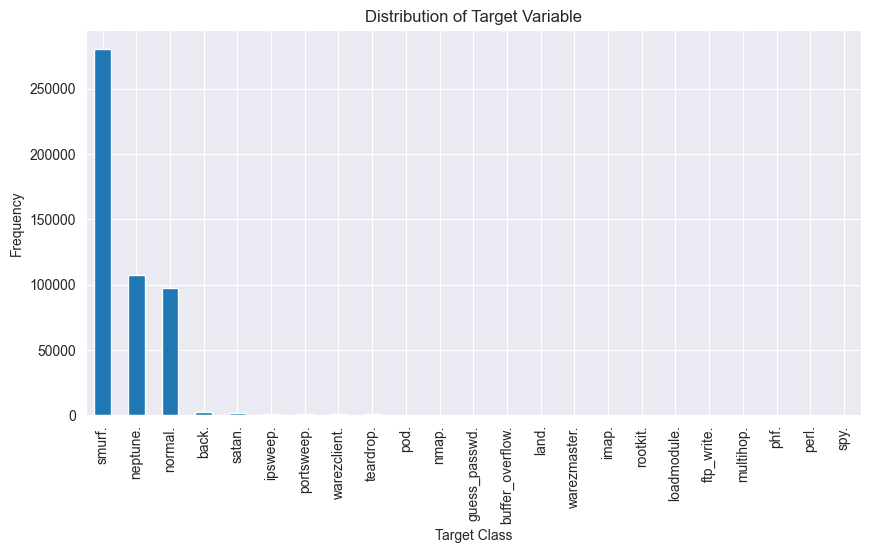

In [13]:
plt.figure(figsize=(10, 5))
df['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Class')
plt.ylabel('Frequency')
plt.show();

The bar chart shows the distribution of the target classes in the dataset. It is evident that the dataset is highly imbalanced. The class "smurf" and "neptune" dominate the dataset, while many other classes have significantly fewer instances.

1. Highly Imbalanced: Classes like "smurf" and "neptune" have a very high number of instances compared to other types of network intrusions or normal behavior. This imbalance could bias the machine learning models towards these over-represented classes.

2. Rare Classes: There are also classes with very few instances. These could be more complex or rare types of network intrusions that are under-represented in the dataset.

3. Normal vs Attacks: The number of instances representing normal behavior is also comparatively low, reinforcing the need for techniques to handle class imbalance.

Given the imbalanced nature of the target variable, techniques like resampling, weighted loss, or anomaly detection approaches might be necessary during the modeling phase to ensure that the model performs well across all classes.

## Correlation Matrix
A correlation matrix will help us understand the linear relationships between numerical variables.

In [87]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show();

ValueError: could not convert string to float: 'tcp'

<Figure size 1500x1000 with 0 Axes>

# Phase 3: Data Preprocessing

## Handle Class Imbalance
The target variable is highly imbalanced, with certain classes dominating the dataset. To address this, we will employ resampling techniques.


In [15]:
from sklearn.utils import resample

# Identify the majority class
majority_class = df['target'].value_counts().idxmax()
minority_class = df['target'].value_counts().index[1]  # second largest class

# Separate majority and minority classes
df_majority = df[df.target == majority_class]
df_minority = df[df.target == minority_class]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=123)  # reproducible results

# Combine downsampled majority class with minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled['target'].value_counts()

target
smurf.      107201
neptune.    107201
Name: count, dtype: int64

## Category Encoding
We have categorical variables like 'protocol_type', 'service', and 'flag' that need to be converted to numerical form.


In [16]:
df_encoded = pd.get_dummies(df_downsampled, columns=['protocol_type', 'service', 'flag'], drop_first=True)

In [17]:
df_encoded

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_systat,service_telnet,service_time,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_RSTO,flag_S0,flag_SF
224085,0,1032,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
47870,0,1032,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
101717,0,1032,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
324557,0,1032,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
424660,0,520,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486878,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
486879,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,True,False
486880,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,True,False
486881,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


## Data Normalization
Features have different ranges and units. We will normalize these features to make them comparable.


In [18]:
scaler = StandardScaler()
features_to_scale = df_encoded.columns.difference(['target'])
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

In [19]:
df_encoded.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_systat,service_telnet,service_time,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_RSTO,flag_S0,flag_SF
224085,0.0,1.152538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022964,-0.030326,-0.021923,-0.02203,-0.022135,-0.021709,-0.022345,-0.046116,-0.82432,1.0
47870,0.0,1.152538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022964,-0.030326,-0.021923,-0.02203,-0.022135,-0.021709,-0.022345,-0.046116,-0.82432,1.0
101717,0.0,1.152538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022964,-0.030326,-0.021923,-0.02203,-0.022135,-0.021709,-0.022345,-0.046116,-0.82432,1.0
324557,0.0,1.152538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022964,-0.030326,-0.021923,-0.02203,-0.022135,-0.021709,-0.022345,-0.046116,-0.82432,1.0
424660,0.0,0.105659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022964,-0.030326,-0.021923,-0.02203,-0.022135,-0.021709,-0.022345,-0.046116,-0.82432,1.0


# Phase 4: Feature Selection

## Feature Importance
Before moving to model building, we will use tree-based classifiers like Random Forest to identify important features that contribute most to our target variable.


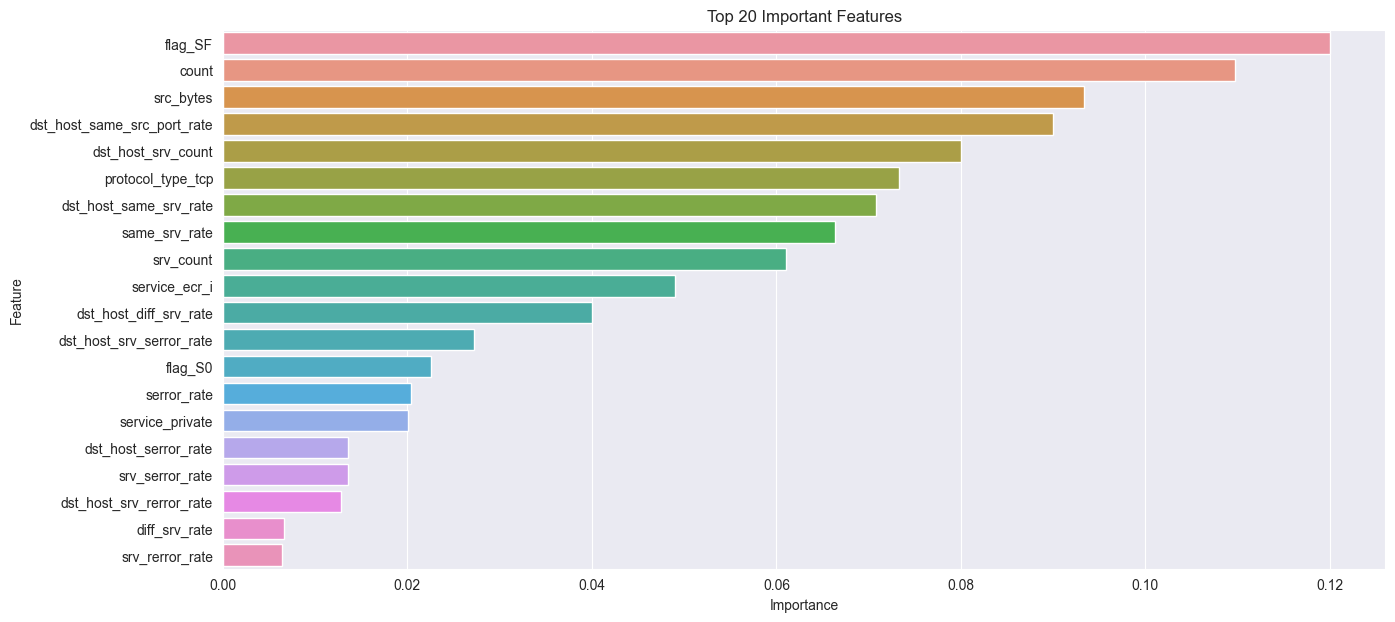

In [88]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=123)

# Fit the model
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(15, 7))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20))
plt.title('Top 20 Important Features')
plt.show();


1. `flag_SF` and `count`: These are the top two features, with importance scores of approximately 0.12 and 0.11, respectively. These features contribute significantly to the model's decision-making process.

2. `src_bytes` and `dst_host_same_src_port_rate`: These features also have high importance scores around 0.09. These might be key in identifying specific types of network behavior.

3. Categorical Features: Several encoded categorical features like `protocol_type_tcp` and `service_ecr_i` also rank high in importance, suggesting that these categorical variables are critical in predicting the target variable.

4. Features with Zero Importance: Numerous features have zero importance. These features can potentially be dropped to simplify the model without sacrificing performance.

# Phase 5: Dynamic Graph Embeddings

## Dynamic Graph Construction
To begin with, we'll construct a dynamic graph using features like 'protocol_type', 'service', and 'flag' as nodes. Edges will be weighted by the 'count' feature, signifying the number of connections.


In [21]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target'],
      dtype='object')

In [22]:
# Initialize an empty list to hold our sequence of graph snapshots
dynamic_graphs = []
time_interval = 20000  # Set your own time interval

for i in range(0, df.shape[0], time_interval):
    G = nx.Graph()
    snapshot = df[i:i + time_interval]
    for _, row in snapshot.iterrows():
        node1 = (row['protocol_type'], row['service'], row['flag'])
        node2 = (row['dst_host_count'], row['dst_host_srv_count'])
        G.add_edge(node1, node2, weight=row['count'])
    dynamic_graphs.append(G)

## Dynamic Graph Visualization
Visualizing the graph will help us understand its structure and the relationships between nodes. For simplicity, we will visualize one snapshot of our dynamic graph.


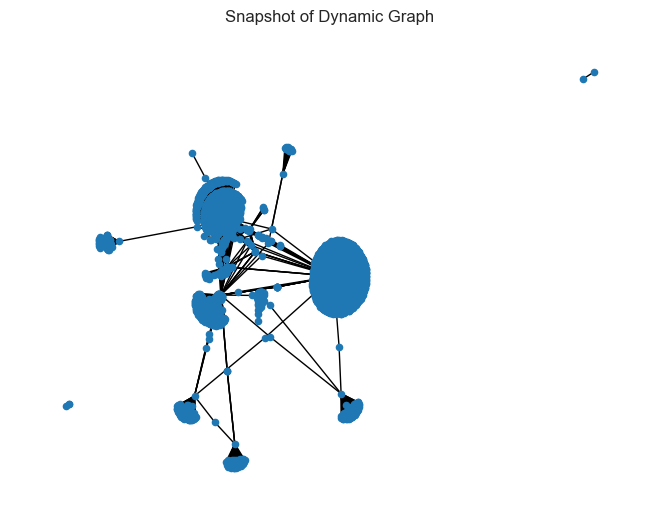

In [23]:
# Visualize one of the snapshot graphs, let's say the first one
nx.draw(dynamic_graphs[0], with_labels=False, node_size=20)
plt.title('Snapshot of Dynamic Graph')
plt.show();

## Multiple Dynamic Graph Visualizations
For a more comprehensive view, we'll visualize six snapshots of our dynamic graphs. Different colors will be used to distinguish each snapshot.


/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


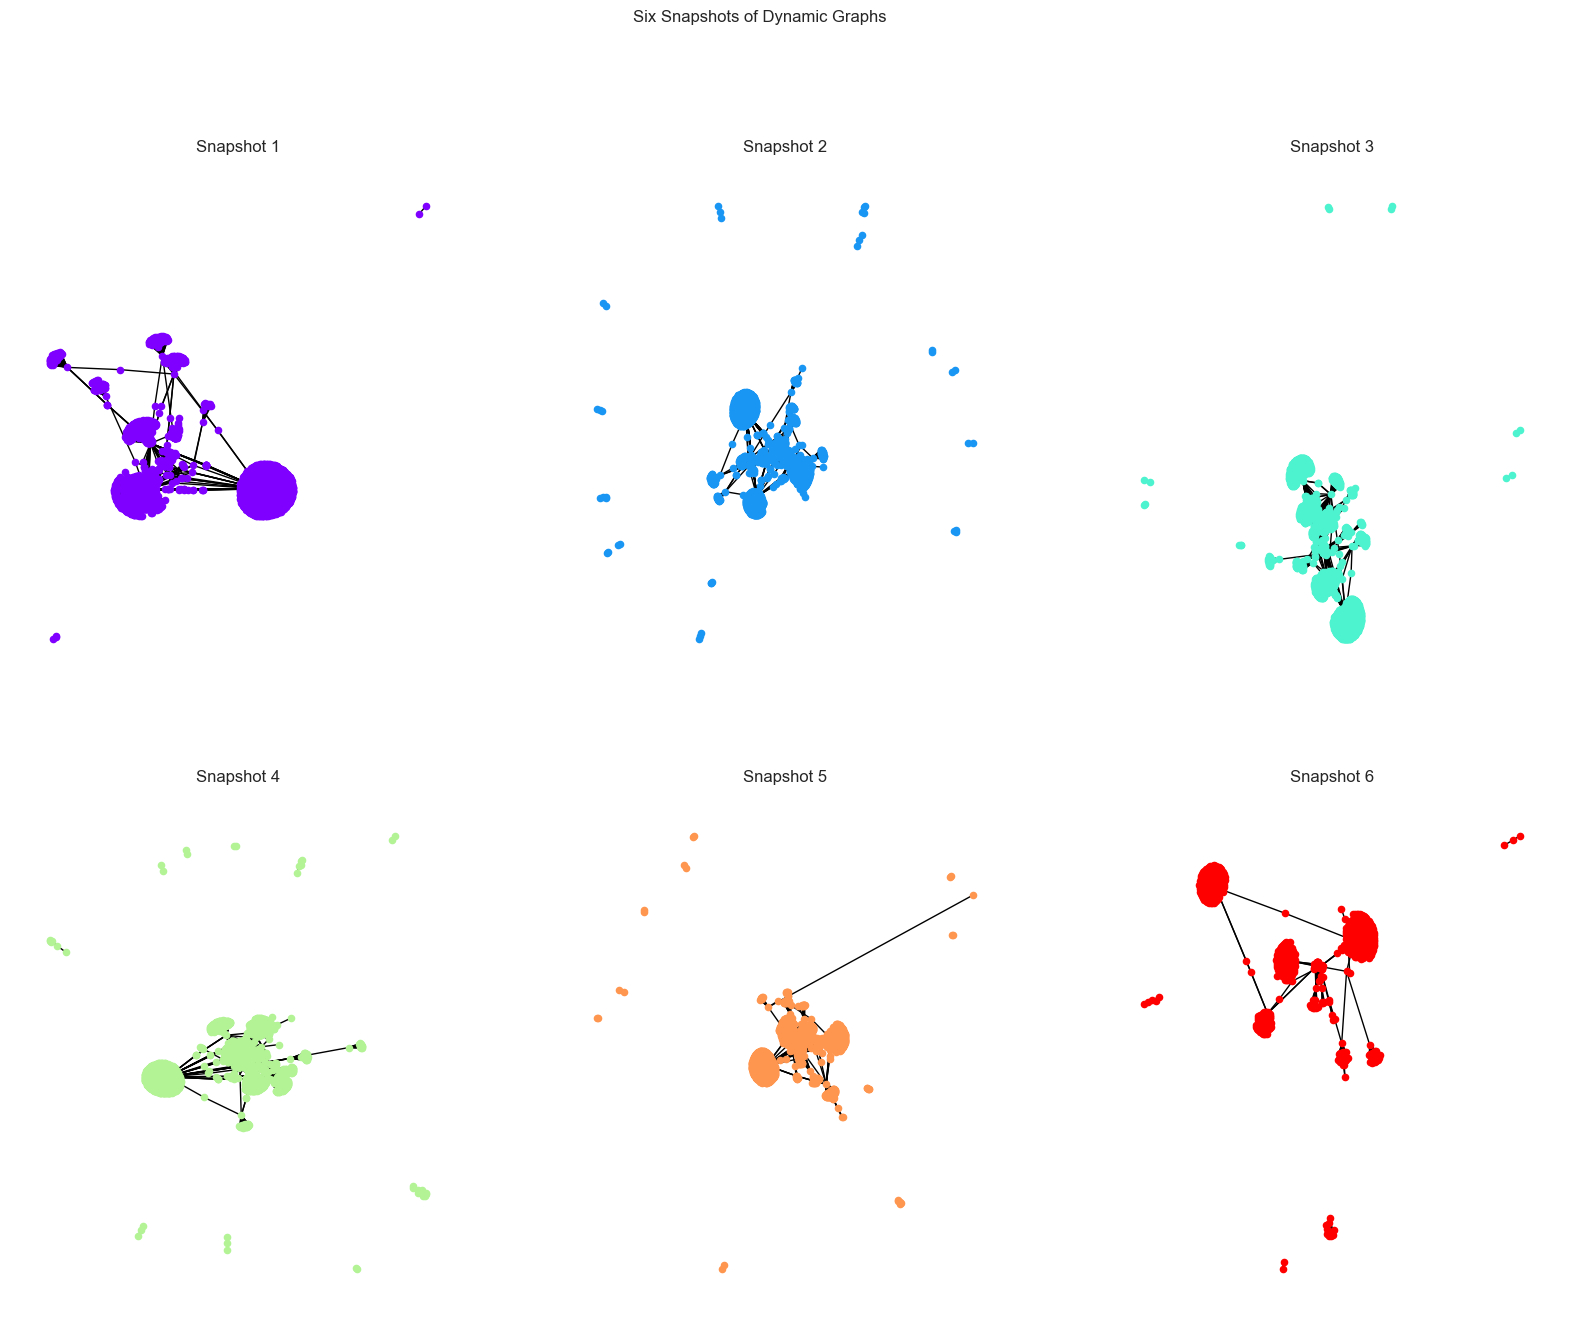

In [24]:
plt.figure(figsize=(20, 15))

colors = cm.rainbow(np.linspace(0, 1, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    nx.draw(dynamic_graphs[i], with_labels=False, node_size=20, node_color=colors[i])
    plt.title(f'Snapshot {i+1}')

plt.suptitle('Six Snapshots of Dynamic Graphs')
plt.show();

## First Snapshot Visualization
The first graph showcases the network interactions at the initial time interval. Each node represents a unique combination of 'protocol_type', 'service', and 'flag' or a unique combination of 'dst_host_count' and 'dst_host_srv_count'. Edges signify the interaction frequency between these nodes.


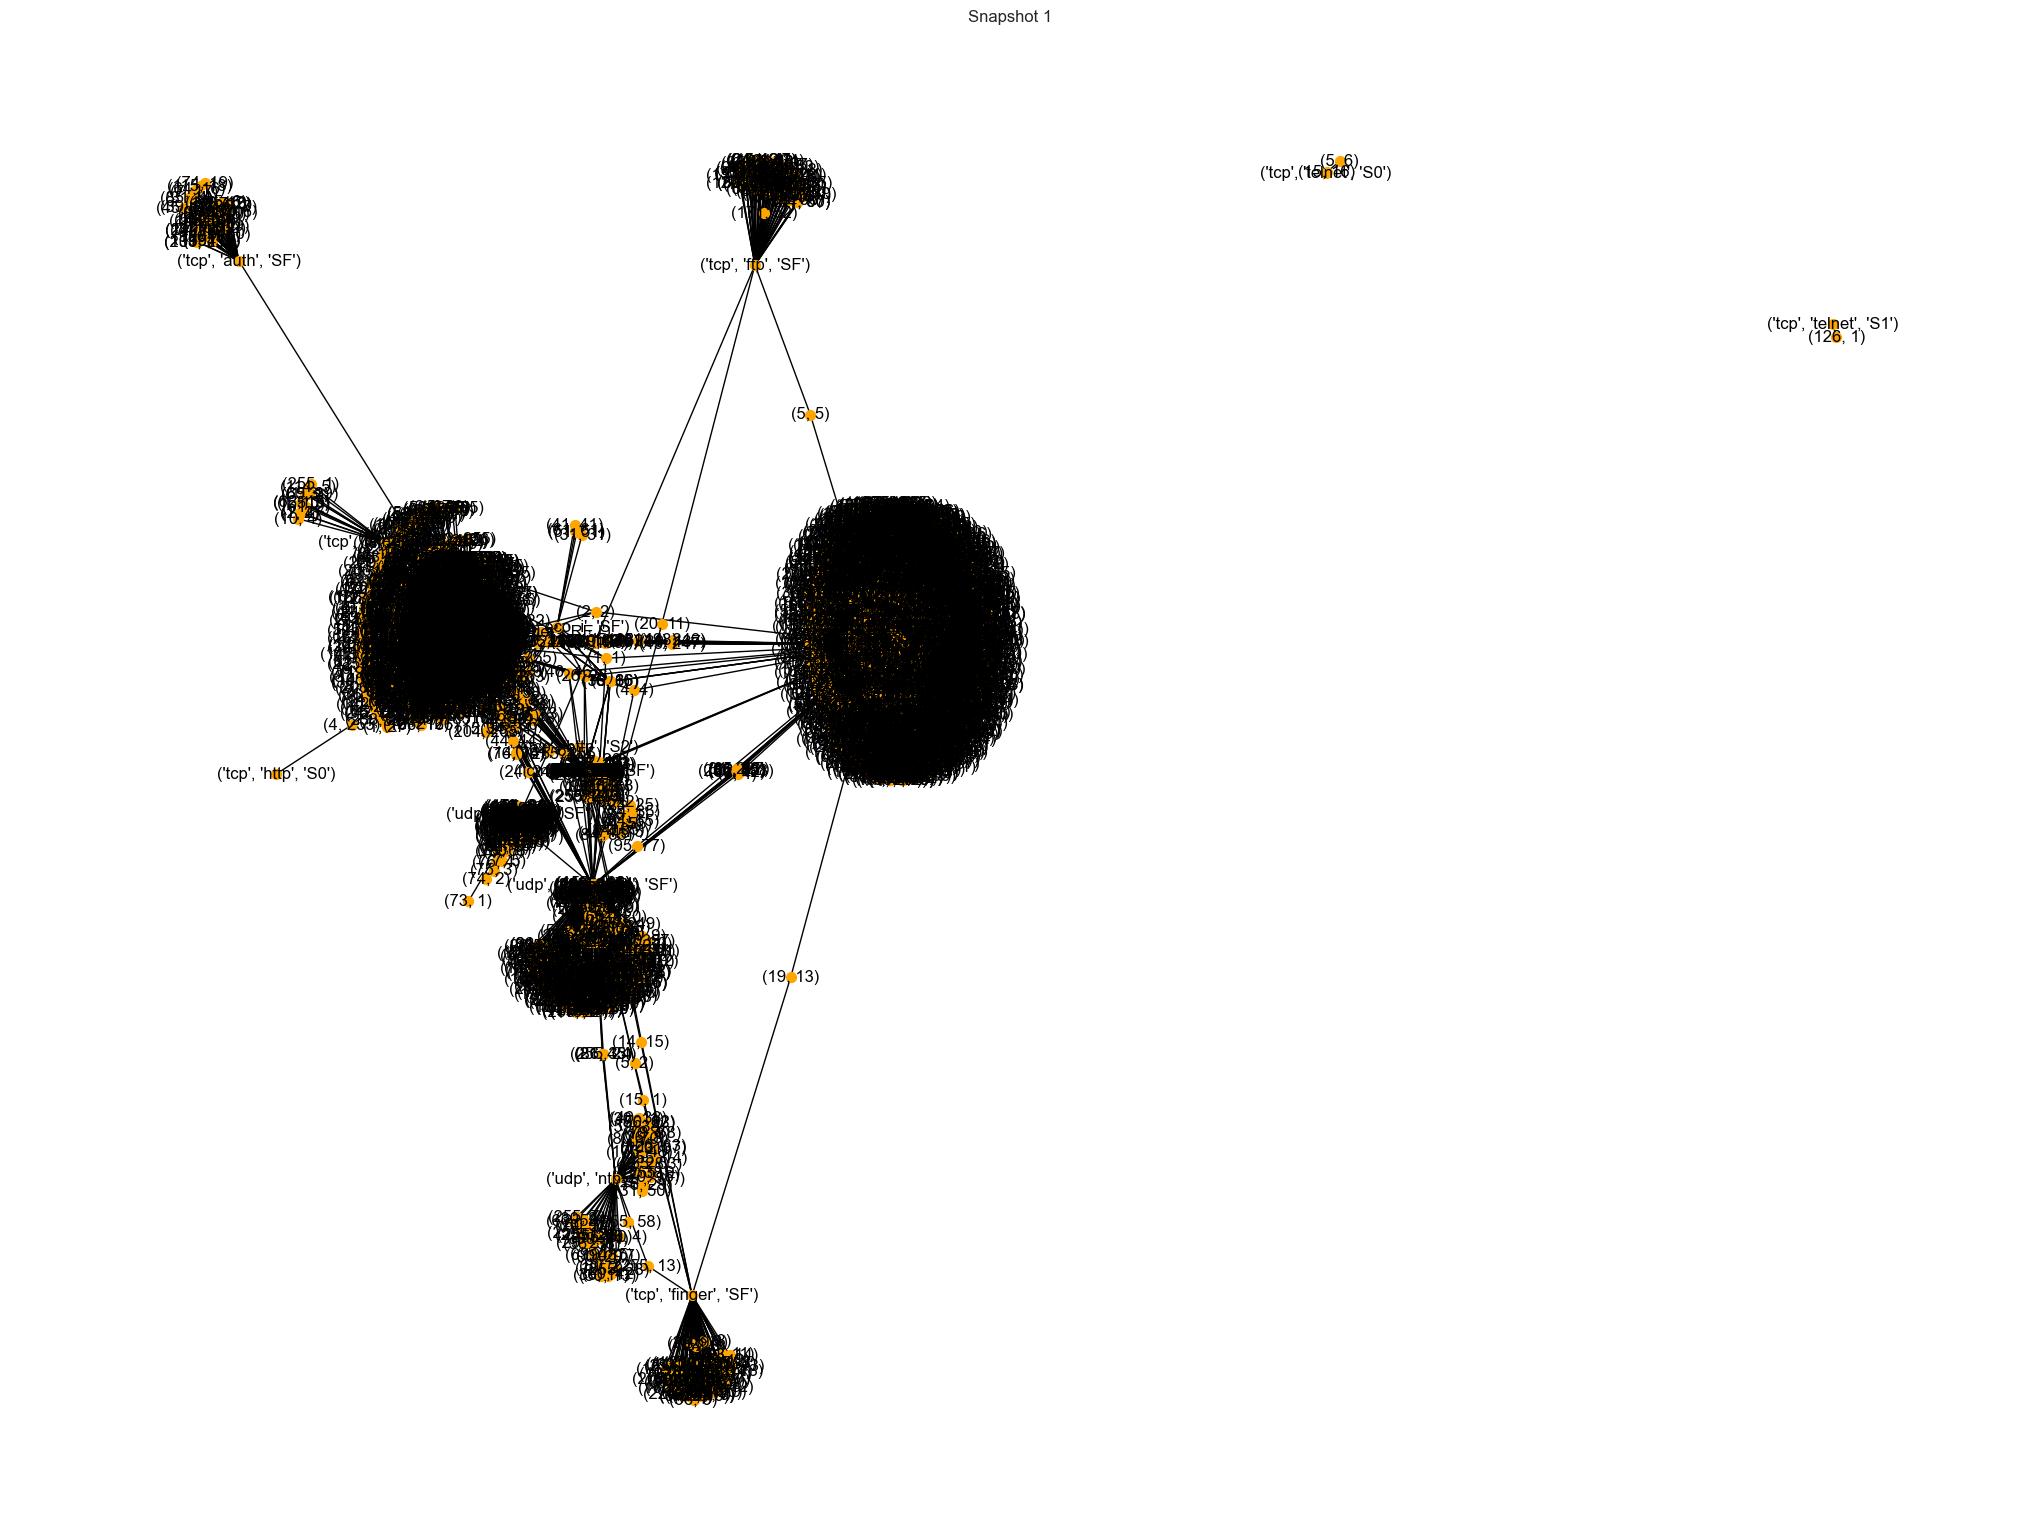

In [25]:
plt.figure(figsize=(20, 15))
nx.draw(dynamic_graphs[0], with_labels=True, node_size=50, node_color='orange')
plt.title('Snapshot 1')
plt.show();

### Understanding Nodes
In our visualizations, nodes can represent two types of entities:
1. A unique combination of 'protocol_type', 'service', and 'flag' (e.g., `'udp', 'domain_u', 'SF'`). This captures the type of interaction happening over the network.
2. A pair representing 'dst_host_count' and 'dst_host_srv_count' (e.g., `39, 137`). This shows how many hosts and services a particular host has communicated with.

Together, these nodes encapsulate the essence of network interactions.



### Understanding Edges
Edges in the graph connect nodes and are weighted by the 'count' feature, signifying the frequency of interactions between the connected entities. An edge between a node representing 'protocol_type', 'service', and 'flag' and a node representing 'dst_host_count' and 'dst_host_srv_count' indicates that this type of interaction occurred between the hosts and services specified.


### Labels in the Graph
When labels are enabled in the visualization, they display the values that the nodes represent. For example, a label like `'udp', 'domain_u', 'SF'` represents a node that encapsulates interactions over UDP protocol, with a 'domain_u' service and 'SF' flag. Another label like `39, 137` represents a node that is connected to 39 hosts and 137 services.


### Overall Interpretation
Each snapshot graph provides a glimpse into the state of network interactions at a specific time interval. By examining how nodes and edges change or stay the same across snapshots, we can observe the evolving nature of network traffic, which is crucial for real-time anomaly detection.


## Embedding the Dynamic Graphs
In this step, we will convert our dynamic graphs into continuous vector spaces using node2vec, an algorithmic framework for learning continuous feature representations for nodes in networks.


## Remove Isolated Nodes
Before running Node2Vec, we need to make sure that there are no isolated nodes in the graph. Isolated nodes have zero degree and can cause issues during random walk generation.


In [26]:
for G in dynamic_graphs:
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

In [27]:
dynamic_graphs

## Remove Zero-Degree Nodes
Some nodes may have zero degree, causing issues during random walk generation. We remove such nodes before running Node2Vec.


In [28]:
for G in dynamic_graphs:
    zero_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(zero_degree_nodes)

In [29]:
# Update edge weights and convert to directed graph
dynamic_graphs_directed = []

for G in dynamic_graphs:
    for u, v in G.edges():
        G[u][v]['weight'] = 1
    G_directed = G.to_directed()
    dynamic_graphs_directed.append(G_directed)

# Now run Node2Vec on the directed graphs
embeddings = []

for i, G in enumerate(dynamic_graphs_directed):
    try:
        node2vec = Node2Vec(G, dimensions=2, walk_length=2, num_walks=1, workers=1)
        model = node2vec.fit(window=5, min_count=1, batch_words=4)
        embeddings.append(model)
    except Exception as e:
        print(f"An error occurred on graph {i+1}: {e}")

Computing transition probabilities:   0%|          | 0/2682 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 69.13it/s]


Computing transition probabilities:   0%|          | 0/3314 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 47.27it/s]


Computing transition probabilities:   0%|          | 0/2511 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 77.49it/s]


Computing transition probabilities:   0%|          | 0/2616 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 63.11it/s]


Computing transition probabilities:   0%|          | 0/2457 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 52.79it/s]


Computing transition probabilities:   0%|          | 0/1108 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 177.53it/s]


Computing transition probabilities:   0%|          | 0/1093 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 162.28it/s]


Computing transition probabilities:   0%|          | 0/4251 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 6990.51it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 4951.95it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 6657.63it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 3923.58it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 7639.90it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 2571.61it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 3390.71it/s]


Computing transition probabilities:   0%|          | 0/2279 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 46.61it/s]


Computing transition probabilities:   0%|          | 0/942 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 155.74it/s]


Computing transition probabilities:   0%|          | 0/363 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 250.32it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 11491.24it/s]


Computing transition probabilities:   0%|          | 0/2 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 3398.95it/s]


Computing transition probabilities:   0%|          | 0/2510 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


Computing transition probabilities:   0%|          | 0/87 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 1319.38it/s]


Computing transition probabilities:   0%|          | 0/1968 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


In [30]:
embeddings

## Saving Embeddings to Google Drive
To avoid re-computation in case the Colab session terminates, we'll serialize and save the embeddings into the Google Drive.


In [31]:
# Embeddings path
drive_path = "data/"

# Create a folder for embeddings if not exists
embedding_folder = os.path.join(drive_path, 'Embeddings')
if not os.path.exists(embedding_folder):
    os.makedirs(embedding_folder)

for i, model in enumerate(embeddings):
    # Serialize the model
    with open(os.path.join(embedding_folder, f'embedding_{i+1}.pkl'), 'wb') as f:
        pickle.dump(model, f)

## Visualizing Embeddings
To understand the quality of our embeddings, we'll visualize them using t-SNE, a technique for dimensionality reduction that is well-suited for the visualization of high-dimensional datasets.


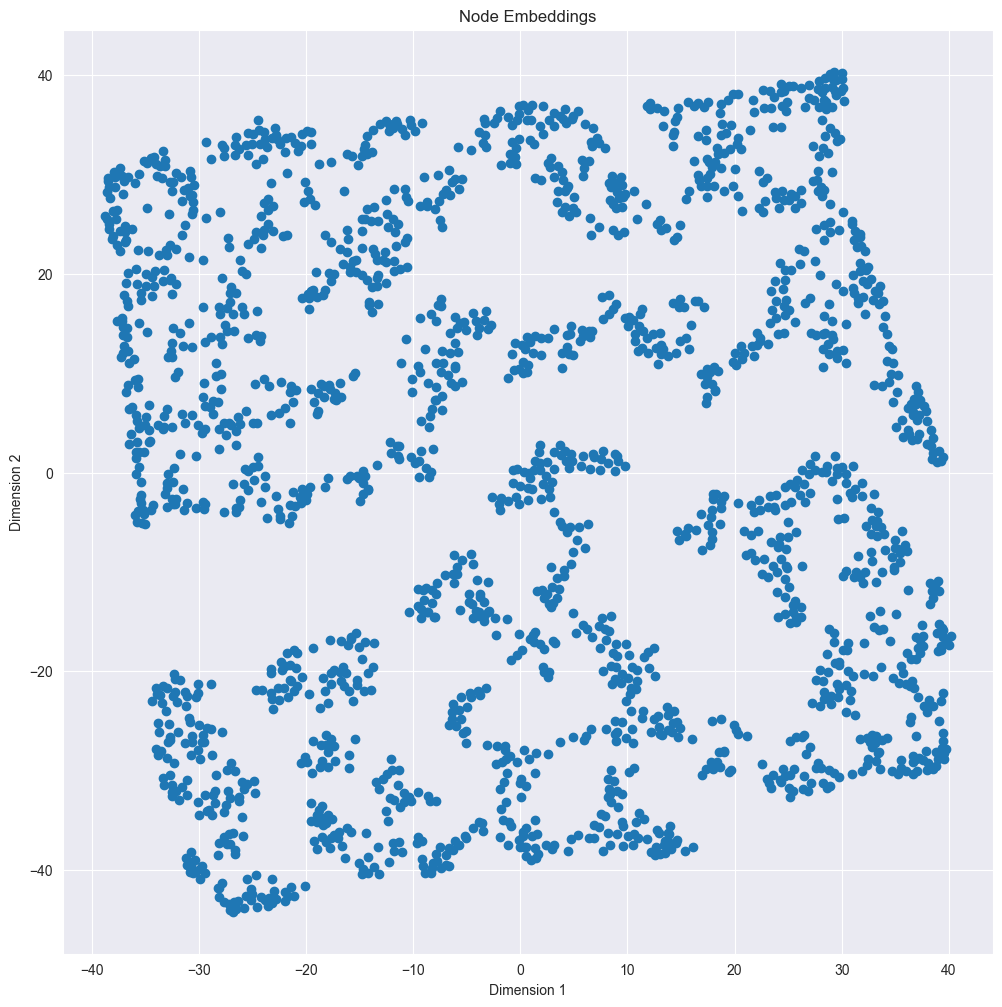

In [32]:
# Get the keys (node labels) from the model
node_ids = model.wv.index_to_key

node_embeddings = [model.wv[node_id] for node_id in node_ids]

# Convert list of node embeddings to a NumPy array
node_embeddings_array = np.array(node_embeddings)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings_array)

# Create a scatter plot
plt.figure(figsize=(12, 12))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.title('Node Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show();

### Interpretation of Embeddings
The scatter plot represents the 2D t-SNE transformation of our graph embeddings. Points that are closer to each other in this space are likely to be closer in the original graph, which implies similar structural roles or properties. This serves as a validation of the quality of our embeddings.


## Concatenating Graph Embeddings to Feature Matrix
To make our machine learning models more robust, we will concatenate the dynamic graph embeddings with our original feature matrix. This new feature matrix will be used for training the models.


In [33]:
# Create a DataFrame to hold the embeddings
embeddings_df = pd.DataFrame(embeddings)

# Assign the index as the node ID for easy lookup
embeddings_df.index = [str(i) for i in range(len(embeddings_df))]

# Cast the index of embeddings_df to int64 to match the data type of 'src_bytes' and 'dst_bytes' in df
embeddings_df.index = embeddings_df.index.astype('int64')

# Merge the original DataFrame with the embeddings DataFrame
# Here I'm assuming 'src_bytes' and 'dst_bytes' are the columns you want to merge on. Replace them if they're different in your DataFrame
merged_df_src = pd.merge(df, embeddings_df, left_on='src_bytes', right_index=True, how='left', suffixes=('', '_src'))
merged_df = pd.merge(merged_df_src, embeddings_df, left_on='dst_bytes', right_index=True, how='left', suffixes=('', '_dst'))

# Now, 'merged_df' contains the original data along with the graph embeddings

In [34]:
merged_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', '0', '0_dst'],
      dtype='object')

# Phase 5: Machine Learning Model Building
In this phase, we will train various machine learning models using the enriched DataFrame that includes both the original features and the graph embeddings. We aim to evaluate the performance of traditional machine learning models and compare them with deep learning models to identify the most effective approach for real-time anomaly detection in network traffic.


In [35]:
print(merged_df[['0', '0_dst']].head())

     0 0_dst
0  NaN   NaN
1  NaN   NaN
2  NaN   NaN
3  NaN   NaN
4  NaN   NaN


In [36]:
print(df['src_bytes'].head())
print(embeddings_df.index[:5])

0    181
1    239
2    235
3    219
4    217
Name: src_bytes, dtype: int64
Index([0, 1, 2, 3, 4], dtype='int64')


In [37]:
embeddings_df.reset_index(inplace=True)

In [38]:
embeddings_df.rename(columns={'index': 'src_bytes'}, inplace=True)


In [39]:
merged_df = pd.merge(df, embeddings_df, on='src_bytes', how='left')


In [40]:
merged_df.columns

Index([                   'duration',               'protocol_type',
                           'service',                        'flag',
                         'src_bytes',                   'dst_bytes',
                              'land',              'wrong_fragment',
                            'urgent',                         'hot',
                 'num_failed_logins',                   'logged_in',
                   'num_compromised',                  'root_shell',
                      'su_attempted',                    'num_root',
                'num_file_creations',                  'num_shells',
                  'num_access_files',           'num_outbound_cmds',
                     'is_host_login',              'is_guest_login',
                             'count',                   'srv_count',
                       'serror_rate',             'srv_serror_rate',
                       'rerror_rate',             'srv_rerror_rate',
                     'same_srv_rat

In [41]:
# Convert all column names to string
merged_df.columns = merged_df.columns.astype(str)

# Perform one-hot encoding for the categorical features
X = pd.get_dummies(merged_df[['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', '0']], drop_first=True)
y = merged_df['target']

# Re-run your code for splitting the data and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Classifier:
Accuracy: 0.9980770203937047


/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-

                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       435
buffer_overflow.       1.00      0.56      0.71         9
      ftp_write.       1.00      1.00      1.00         1
   guess_passwd.       1.00      0.88      0.93         8
           imap.       1.00      0.67      0.80         3
        ipsweep.       0.90      0.93      0.91       265
           land.       0.00      0.00      0.00         1
     loadmodule.       0.33      0.50      0.40         2
       multihop.       0.00      0.00      0.00         1
        neptune.       0.99      1.00      1.00     21294
           nmap.       0.95      0.42      0.58        45
         normal.       1.00      1.00      1.00     19353
           perl.       0.00      0.00      0.00         1
            pod.       1.00      1.00      1.00        38
      portsweep.       0.99      0.77      0.87       236
        rootkit.       0.00      0.00      0.00         0
          sat

/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1. Handling Imbalanced Data with SMOTE
Synthetic Minority Over-sampling Technique (SMOTE) can help balance the dataset by generating synthetic samples in the feature space.

In [42]:
# Initialize SMOTE with k_neighbors set to 1
smote = SMOTE(k_neighbors=1, random_state=42)

# Fit and transform original data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [43]:
X_resampled.shape

(5160924, 98)

In [44]:
y_resampled.shape

(5160924,)

### 2. Hyperparameter Tuning with GridSearchCV
Optimizing hyperparameters can help the model generalize better.

In [45]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Create GridSearch object with RandomForestClassifier
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=2, verbose=2)

# Fit data to GridSearch
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best params are: {best_params}")

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 8.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 9.3min
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time= 2.4min
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time= 2.5min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 4.3min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 4.6min
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 8.5min
[CV] END max_depth=None, min_s

### 3. Re-train the Model with Best Parameters and Resampled Data

In [48]:
# Initialize and train the RandomForestClassifier with best parameters
rf_clf_best = RandomForestClassifier(**best_params, random_state=42)
rf_clf_best.fit(X_resampled, y_resampled)

# Predictions and Evaluation
y_pred_best = rf_clf_best.predict(X_test)
print("Random Forest Classifier with Hyperparameter Tuning and SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Random Forest Classifier with Hyperparameter Tuning and SMOTE:
Accuracy: 0.9583826729416528


/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-

                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       435
buffer_overflow.       1.00      0.67      0.80         9
      ftp_write.       0.03      1.00      0.06         1
   guess_passwd.       1.00      0.88      0.93         8
           imap.       1.00      1.00      1.00         3
        ipsweep.       0.82      0.93      0.87       265
           land.       0.02      1.00      0.04         1
     loadmodule.       0.33      0.50      0.40         2
       multihop.       0.00      0.00      0.00         1
        neptune.       1.00      0.81      0.90     21294
           nmap.       0.95      0.42      0.58        45
         normal.       1.00      1.00      1.00     19353
           perl.       0.00      0.00      0.00         1
            pod.       1.00      1.00      1.00        38
      portsweep.       0.06      0.98      0.11       236
        rootkit.       0.00      0.00      0.00         0
          sat

/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
y_pred, y_pred_best

(array(['smurf.', 'smurf.', 'smurf.', ..., 'normal.', 'smurf.', 'normal.'],
       dtype=object),
 array(['smurf.', 'smurf.', 'smurf.', ..., 'normal.', 'smurf.', 'normal.'],
       dtype=object))

#### Confusion matrix for multiclass RF model

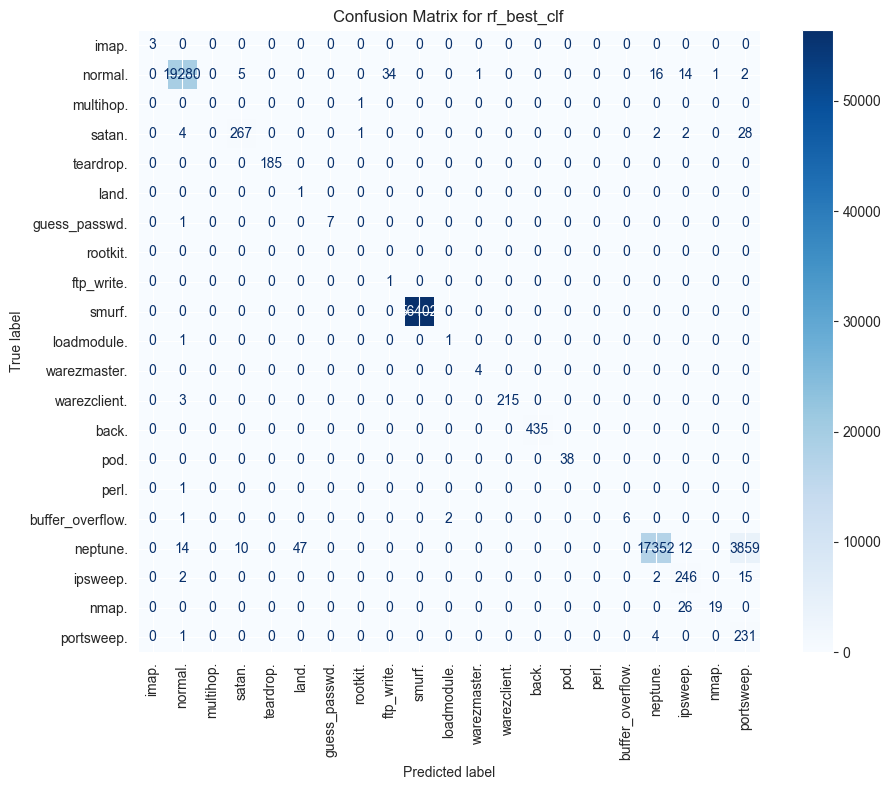

In [60]:
# Extract all unique labels from both y_test and y_pred_best
all_labels = list(set(y_test.unique()) | set(y_pred_best))

# Compute confusion matrix with all possible labels
cm_best = confusion_matrix(y_test, y_pred_best, labels=all_labels)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=all_labels)
disp_best.plot(cmap="Blues", ax=ax, xticks_rotation='vertical')
ax.set_title("Confusion Matrix for rf_best_clf")
plt.tight_layout()
plt.show();

#### ROC Curve for multiclass RF model

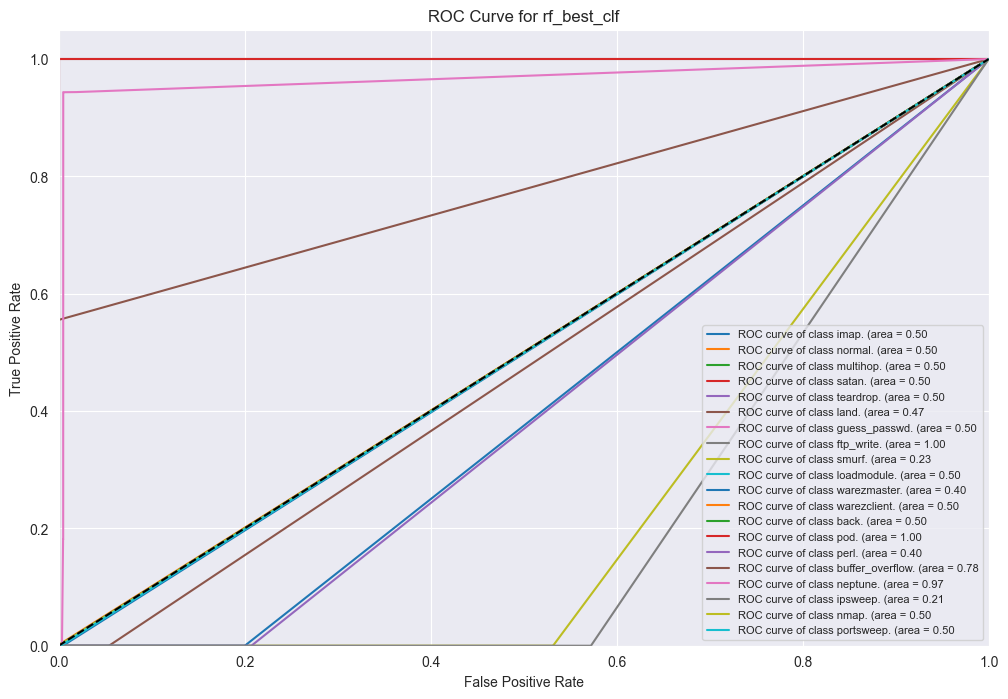

In [61]:
# Identify the classes that are present in the y_test set
unique_classes = y_test.unique()

# Binarize the output
y_test_bin = label_binarize(y_test, classes=all_labels)
y_pred_prob = rf_clf_best.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Plot ROC curves only for classes present in y_test
plt.figure(figsize=(12, 8))

for i, label in enumerate(all_labels):
    if label in unique_classes:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])

        # Check if the ROC curve is well-defined for this class
        if len(np.unique(y_test_bin[:, i])) == 1:  # Only one class present
            continue

        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label} (area = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for rf_best_clf')
plt.legend(loc="lower right", fontsize=8)
plt.show();

### 5. Model performance with XGBoost Classifier

#### 5.1. Prepare the Data for XGBoost:

In [72]:
# Initialize the label encoder
encoder = LabelEncoder()

# Fit the encoder on the resampled target labels
encoder.fit(y_resampled)

# Transform the target labels
y_resampled_encoded = encoder.transform(y_resampled)
y_test_encoded = encoder.transform(y_test)

# Ensure both datasets have the same columns in the same order
missing_cols = set(X_resampled.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0

X_test = X_test[X_resampled.columns]

# Ensure no duplicate column names and problematic characters
X_resampled = X_resampled.rename(columns=lambda x: x.replace("[", "").replace("]", "").replace("<", "").replace("=", "_").replace(",", ""))
X_test = X_test.rename(columns=lambda x: x.replace("[", "").replace("]", "").replace("<", "").replace("=", "_").replace(",", ""))

X_resampled.columns = [str(i) + "_" + col if col.startswith('0_Word2Vec') else col for i, col in enumerate(X_resampled.columns)]
X_test.columns = [str(i) + "_" + col if col.startswith('0_Word2Vec') else col for i, col in enumerate(X_test.columns)]

# Encode the labels
encoder = LabelEncoder()
y_resampled_encoded = encoder.fit_transform(y_resampled)
y_test_encoded = encoder.transform(y_test)

#### 5.2. Train an XGBoost Classifier:

In [78]:
# Create a DMatrix for more efficiency
dtrain = xgb.DMatrix(X_resampled, label=y_resampled_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# Set the parameters
param = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': len(encoder.classes_)
}

# Train the model
num_round = 20
bst = xgb.train(param, dtrain, num_round)

# Predict the classes
preds = bst.predict(dtest)
best_preds = [int(np.argmax(value)) for value in preds]

#### 5.3 Prepare unique labels for confusion matrix

In [79]:
# Determine unique classes in y_test_encoded and best_preds
unique_labels = np.unique(np.concatenate((y_test_encoded, best_preds)))

# Use these unique labels to fetch the corresponding class names
label_names = encoder.inverse_transform(unique_labels)

# Print the classification report using the fetched class names
print("Accuracy = {}".format(accuracy_score(y_test_encoded, best_preds)))
print(classification_report(y_test_encoded, best_preds, labels=unique_labels, target_names=label_names))

Accuracy = 0.9571884013966905
                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       435
buffer_overflow.       0.80      0.44      0.57         9
      ftp_write.       0.02      1.00      0.04         1
   guess_passwd.       0.78      0.88      0.82         8
           imap.       1.00      1.00      1.00         3
        ipsweep.       0.75      0.69      0.72       265
           land.       0.02      1.00      0.04         1
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         1
        neptune.       1.00      0.81      0.90     21294
           nmap.       0.23      0.42      0.30        45
         normal.       1.00      0.99      1.00     19353
           perl.       0.00      0.00      0.00         1
            pod.       1.00      1.00      1.00        38
      portsweep.       0.06      0.98      0.11       236
        rootkit.       0.00      0.00    

/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-

### 6. Compare RF and XGBoosts model performce


In [82]:
# Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_best)
rf_report = classification_report(y_test, y_pred_best)

# XGBoost
xgb_accuracy = accuracy_score(y_test_encoded, best_preds)
xgb_report = classification_report(y_test_encoded, best_preds, labels=unique_labels, target_names=label_names)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

print("\nXGBoost Accuracy:", xgb_accuracy)
print("XGBoost Classification Report:\n", xgb_report)

Random Forest Accuracy: 0.9583826729416528
Random Forest Classification Report:
                   precision    recall  f1-score   support

           back.       1.00      1.00      1.00       435
buffer_overflow.       1.00      0.67      0.80         9
      ftp_write.       0.03      1.00      0.06         1
   guess_passwd.       1.00      0.88      0.93         8
           imap.       1.00      1.00      1.00         3
        ipsweep.       0.82      0.93      0.87       265
           land.       0.02      1.00      0.04         1
     loadmodule.       0.33      0.50      0.40         2
       multihop.       0.00      0.00      0.00         1
        neptune.       1.00      0.81      0.90     21294
           nmap.       0.95      0.42      0.58        45
         normal.       1.00      1.00      1.00     19353
           perl.       0.00      0.00      0.00         1
            pod.       1.00      1.00      1.00        38
      portsweep.       0.06      0.98      0.11 

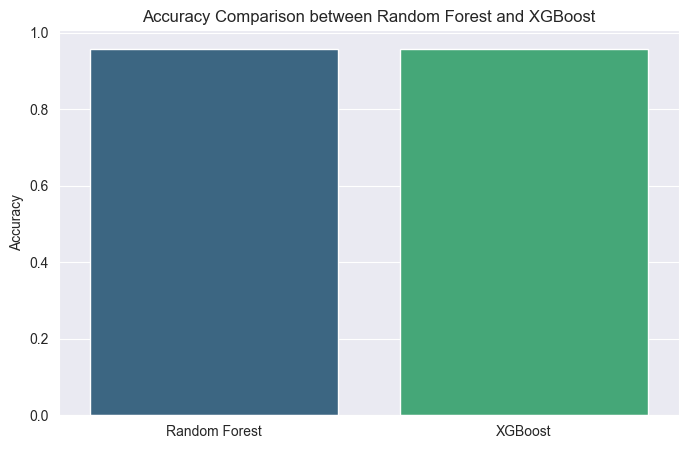

In [84]:
# Bar chart for accuracy comparison
labels = ['Random Forest', 'XGBoost']
accuracies = [rf_accuracy, xgb_accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=accuracies, palette='viridis')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Random Forest and XGBoost')
plt.show();

#### 6.1 Confusion matrix comparision


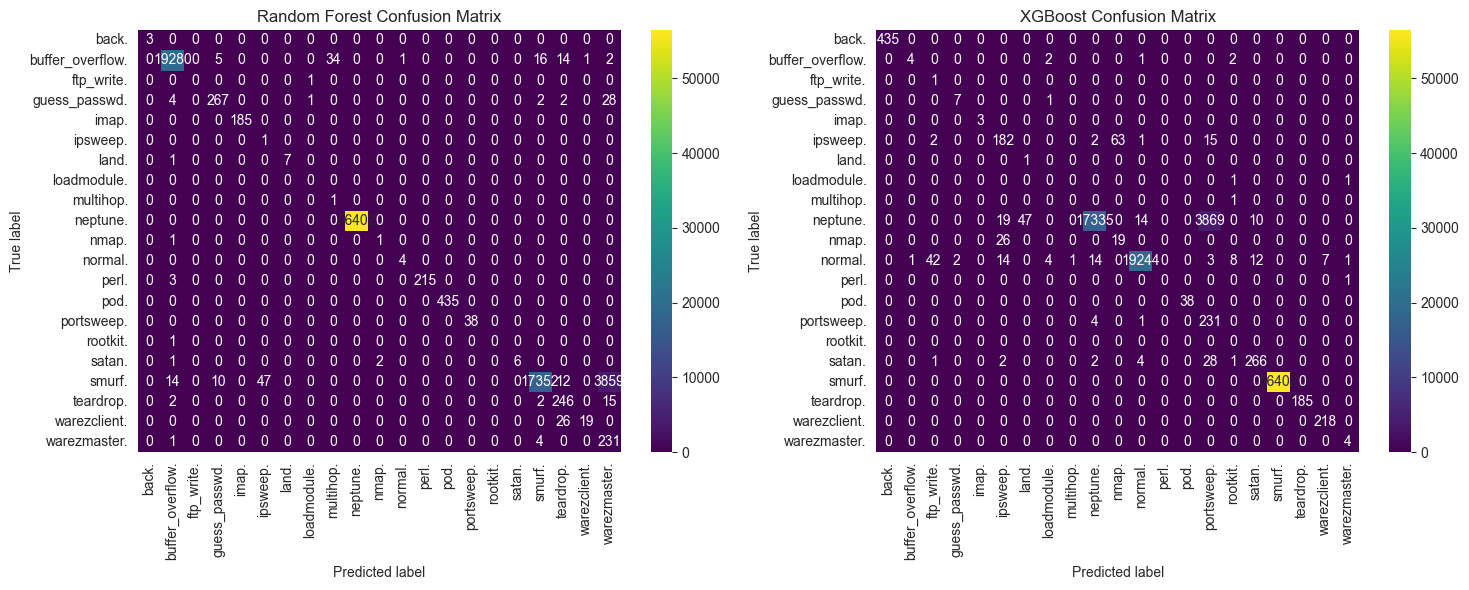

In [85]:
# Confusion matrices
rf_cm = confusion_matrix(y_test, y_pred_best, labels=all_labels)
xgb_cm = confusion_matrix(y_test_encoded, best_preds)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.heatmap(rf_cm, annot=True, cmap='viridis', fmt='g', xticklabels=label_names, yticklabels=label_names)
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1, 2, 2)
sns.heatmap(xgb_cm, annot=True, cmap='viridis', fmt='g', xticklabels=label_names, yticklabels=label_names)
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.show();

# Phase 6: Real-time Anomaly Detection

Turning our model into a real-time anomaly detection system involves several steps.

### 1. **Data Collection in Real-Time**:

   - **Source Integration**: Determine where our real-time data is coming from. This could be network logs, system logs, user behavior data, etc. We want to make sure that we can access and stream this data in real-time.

   - **Preprocessing**: As new data comes in, we'll need to preprocess it in the same way as your training data. This includes feature extraction, transformation, scaling, and encoding.

### 2. **Model Deployment**:

   - **Hosting the Model**: The trained Random Forest model needs to be saved and then loaded into a production environment. Consider using libraries like `joblib` or `pickle` in Python for model serialization and deserialization.

   - **API Integration**: Often, the model will be hosted on a server and accessed via API calls. Solutions like Flask, FastAPI, or Django in Python can be used to create these APIs. Alternatively, cloud platforms offer services like AWS SageMaker or Azure Machine Learning for deploying models.

### 3. **Real-Time Prediction**:

   - As new data points come in, they are sent to the model (either locally or via API). The model then predicts if each data point is an anomaly or not.

   - **Thresholding**: Depending on the nature of your data and the cost of false positives vs. false negatives, you might want to adjust the decision threshold for your model. This can help in fine-tuning the sensitivity of your anomaly detection.

### 4. **Alerts and Monitoring**:

   - If an anomaly is detected, an alert can be triggered. This could be an email, SMS, dashboard update, or any other kind of notification.

   - Monitor the performance of your system. Over time, as the nature of the data changes, the model might need to be retrained. Keep track of false positives and false negatives, and consider setting up a feedback loop where the model can be updated with new labeled examples.

### 5. **Feedback Loop for Continuous Learning**:

   - As the system makes predictions in real-time, there will inevitably be some false positives and false negatives. It's beneficial to have a mechanism where these can be labeled correctly and fed back into the training set. This allows the model to be periodically retrained and improved.

### 6. **Scalability and Performance**:

   - Ensure that the system can handle the volume of real-time data. This might involve optimizing the preprocessing steps, using a faster hardware setup, or even simplifying the model if necessary.

   - **Batch Processing**: If real-time isn't strictly necessary and there's a short allowable delay, consider processing data in small batches rather than one-by-one. This can often be more efficient.

### 7. **Security**:

   - If you're deploying the model as an API, ensure that it's secure. This involves setting up authentication, possibly rate limiting, and ensuring data privacy.

### 8. **Regular Maintenance**:

   - Models can "drift" over time if the underlying data patterns change. Regularly monitor and retrain your model to ensure it remains effective.

To summarize, turning your Random Forest model into a real-time anomaly detection system requires a combination of software engineering, system design, and continuous monitoring and maintenance. It's not just about the model but also about how it's integrated into a larger system.

> **As we can see from above comparision, Random Forest Classifier model perform slightly better thatn XGBoots model. Hence, we are moving forward with RF Classier for real time anomaly detection**

In [90]:
# Save Random forest classifier for future use
with open('models/rf_best_model.pkl','wb') as f:
    pickle.dump(rf_clf_best,f)

# Also saving XGB model in case we want to use it for further model evaluation
with open('models/xgb_model.pkl','wb') as f:
    pickle.dump(bst,f)